In [231]:
### Data import

import pandas as pd

# data = pd.read_csv('loans.csv', delimiter=';', decimal=',')
data = pd.read_csv('loans.csv', delimiter=';', decimal=',')

print(data.head())


   Debt_to_Income_Ratio  FICO_Score  Request_Amount  Interest  Approval
0                   0.0         397            1000       450         0
1                   0.0         403             500       225         0
2                   0.0         408            1000       450         0
3                   0.0         408            2000       900         0
4                   0.0         411            5000      2250         0


In [232]:
### Seed generation

import numpy as np

indexes = [
    297058, 297059, 297090, 297061, 297062, 297063, 297064, 297065, 297066, 297067, 303927, 294721, 302918, 392018, 301893
]

seed = np.floor(np.mean(indexes)).astype(int)

print('Seed: %d' % seed)


Seed: 304408


In [233]:
# Exploratory data analysis

## Overall data information

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150302 entries, 0 to 150301
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Debt_to_Income_Ratio  150302 non-null  float64
 1   FICO_Score            150302 non-null  int64  
 2   Request_Amount        150302 non-null  int64  
 3   Interest              150302 non-null  int64  
 4   Approval              150302 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 5.7 MB


In [234]:
### Missing values check

data.isnull().sum()

Debt_to_Income_Ratio    0
FICO_Score              0
Request_Amount          0
Interest                0
Approval                0
dtype: int64

In [349]:
### Data correlation
correlation = data.corr()
correlation.where(lambda x: x > 0.5)

,Debt_to_Income_Ratio,FICO_Score,Request_Amount,Interest,Approval
Debt_to_Income_Ratio,1.0,NaN,NaN,NaN,NaN
FICO_Score,NaN,1.000000,NaN,NaN,0.544305
Request_Amount,NaN,NaN,1.0,1.0,NaN
Interest,NaN,NaN,1.0,1.0,NaN
Approval,NaN,0.544305,NaN,NaN,1.000000


In [354]:
### Absolute correlation values

correlation.abs()

,Debt_to_Income_Ratio,FICO_Score,Request_Amount,Interest,Approval
Debt_to_Income_Ratio,1.000000,0.070586,0.129207,0.129207,0.267921
FICO_Score,0.070586,1.000000,0.153920,0.153920,0.544305
Request_Amount,0.129207,0.153920,1.000000,1.000000,0.045903
Interest,0.129207,0.153920,1.000000,1.000000,0.045903
Approval,0.267921,0.544305,0.045903,0.045903,1.000000


In [449]:
### Checking for Multicollinearity

## Prepare mask for non-diagonal and close to 1.0 values
mask = np.isclose(correlation, 1.0) & ~np.eye(correlation.shape[0], dtype=bool)

# Apply mask to correlation matrix
high_corr = correlation.where(mask)

# Remove duplicates and drop NaN values
high_corr.stack().drop_duplicates()


Request_Amount  Interest    1.0
dtype: float64

In [451]:
### Correlation values above 0.5 for 'Approval'

correlation.drop(labels='Approval')['Approval'].abs().where(lambda x: x > 0.5).dropna()

FICO_Score    0.544305
Name: Approval, dtype: float64

Model building

In [513]:
### Data split

from sklearn.model_selection import train_test_split

# X = data.drop(columns=['Approval', 'Debt_to_Income_Ratio', 'Interest', 'Request_Amount'])
X = data.drop(columns=['Approval'])
print(X)
y = data['Approval']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True, stratify=y)

        Debt_to_Income_Ratio  FICO_Score  Request_Amount  Interest
0                       0.00         397            1000       450
1                       0.00         403             500       225
2                       0.00         408            1000       450
3                       0.00         408            2000       900
4                       0.00         411            5000      2250
...                      ...         ...             ...       ...
150297                  0.38         709           19000      8550
150298                  0.38         722           17000      7650
150299                  0.38         747           11000      4950
150300                  0.39         679           10000      4500
150301                  0.39         769            7000      3150

[150302 rows x 4 columns]


In [514]:
### Data split check

print(f'Train set: {len(X_train)}', f'Test set: {len(X_test)}')

print(f'Approval in train set: {y_train.value_counts(normalize=True)}')
print(f'Approval in test set: {y_test.value_counts(normalize=True)}')

Train set: 105211 Test set: 45091
Approval in train set: Approval
1    0.500566
0    0.499434
Name: proportion, dtype: float64
Approval in test set: Approval
1    0.500566
0    0.499434
Name: proportion, dtype: float64


In [515]:
### Data transformation for KMeans

## Prepare scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.set_output(transform='pandas')

## Transform data
X_train_scaled = scaler.fit_transform(X_train)

In [516]:
### Transformation of test data using already fitted scaler
X_test_scaled = scaler.transform(X_test)

In [517]:
### Model training - KMeans

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_jobs=-1)

[[43139  9407]
 [ 3781 48884]]


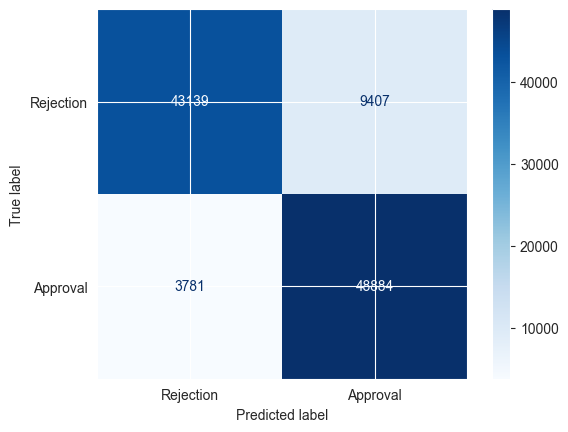

In [518]:
### Model evaluation on training data - Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_train_pred = model.predict(X_train_scaled)
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred), display_labels=['Rejection', 'Approval'])
disp.plot(cmap='Blues')
print(confusion_matrix(y_train, y_train_pred))


In [519]:
### Comparison of sklearn confusion_matrix and score functions

from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, y_train_pred), model.score(X_train_scaled, y_train))

0.8746518900115007 0.8746518900115007


[[17507  5013]
 [ 2579 19992]]


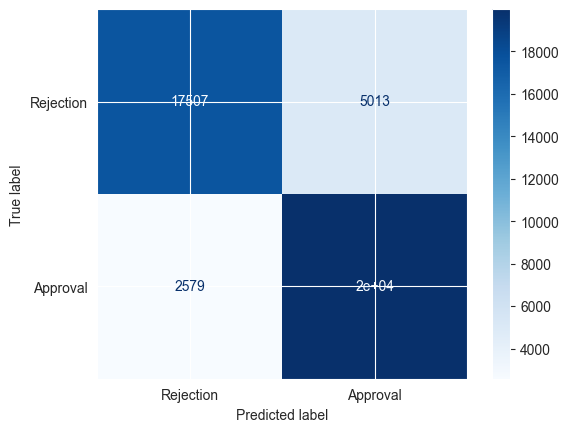

In [520]:
### Model evaluation on test data - Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred = model.predict(X_test_scaled)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=['Rejection', 'Approval'])
disp.plot(cmap='Blues')
print(confusion_matrix(y_test, y_test_pred))


In [521]:
### Comparison of sklearn confusion_matrix and score functions

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.8316293717149764

In [522]:
def ocen_model_klasyfikacji_binarnej(y_true, y_pred, digits = 2):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    overall_error_rate = 1 - accuracy
    sensitivity = tp/(fn+tp)
    fnr = fn/(fn+tp)
    specificity = tn/(tn+fp)
    fpr = fp/(tn+fp)
    precision = tp/(fp+tp)
    f1 = (2 * sensitivity * precision) / (sensitivity + precision)
    print('Trafność: ', round(accuracy, digits))
    print('Całkowity współczynnik błędu', round(overall_error_rate, digits))
    print('Czułość: ', round(sensitivity, digits))
    print('Wskaźnik fałszywie negatywnych: ', round(fnr, digits))
    print('Specyficzność: ', round(specificity, digits))
    print('Wskaźnik fałszywie pozytywnych: ', round(fpr, digits))
    print('Precyzja: ', round(precision, digits))
    print('Wynik F1: ', round(f1, digits))

In [523]:
print('Train set metrics:')
ocen_model_klasyfikacji_binarnej(y_train, y_train_pred)

Train set metrics:
Trafność:  0.87
Całkowity współczynnik błędu 0.13
Czułość:  0.93
Wskaźnik fałszywie negatywnych:  0.07
Specyficzność:  0.82
Wskaźnik fałszywie pozytywnych:  0.18
Precyzja:  0.84
Wynik F1:  0.88


In [524]:
print('Test set metrics:')
ocen_model_klasyfikacji_binarnej(y_test, y_test_pred)

Test set metrics:
Trafność:  0.83
Całkowity współczynnik błędu 0.17
Czułość:  0.89
Wskaźnik fałszywie negatywnych:  0.11
Specyficzność:  0.78
Wskaźnik fałszywie pozytywnych:  0.22
Precyzja:  0.8
Wynik F1:  0.84
